In [1]:
%load_ext tensorboard
from keras.callbacks import TensorBoard
import time , os

In [2]:
from tensorflow import keras
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
import base64
from io import BytesIO
import random
import numpy as np

class AutoEncoder:
    
    def __init__(self,shape_x=28,shape_y=28,channels=1,dense=0,dense_values=[64,32,16],output=64,lRate=0.001,epochs=3,batch_size=32) :
        self.shape_x = shape_x
        self.shape_y = shape_y
        self.channels = channels
        self.autoencoder = None
        self.encoder = None
        self.dense = dense
        self.dense_values = dense_values
        self.output = output
        self.lRate = lRate
        self.epochs = epochs
        self.batch_size = batch_size
        
        (self.X_TRAIN,self.Y_TRAIN),(self.X_TEST,self.Y_TEST) = keras.datasets.mnist.load_data()
    
    def Autoencoder(self,x_data,y_data):
        
        # dense => No of Dense Layers
        # dense_values = is a list of no of cell per dense layer by default they will get value nearest to perfect sq
        # max hidden layer 3
        # output is set to 64 for dense = 0
        
        # may be would add LSTM etc
        
        if self.dense > 3:
            return 'Error- Chossen More than 3 dense layers!!!'
        
        
        #  Encoder -- 
        
        encoder_input = keras.Input((self.shape_x,self.shape_y,self.channels))
        flaten = keras.layers.Flatten()(encoder_input)
        
        dense_layers = []
        
        if self.dense > 0:
            for i in range(self.dense) :
                
                if i == 0 :
                    layer = keras.layers.Dense(self.dense_values[i],activation='relu')(flaten)
                else:
                    layer = keras.layers.Dense(self.dense_values[i],activation='relu')(dense_layers[-1])
                    
                dense_layers.append(layer)
            
       
        if len(dense_layers) == 0:
            encoder_output = keras.layers.Dense(self.output)(flaten)
        else:
            encoder_output = keras.layers.Dense(self.output)(dense_layers[-1])
        
        # Encoder Model
        self.encoder = keras.Model(encoder_input,encoder_output)
        
        # Decoder --
        
        decoder_layers = []
        
        if self.dense > 0:
            for i in range(self.dense-1,-1,-1):
                
                if i == self.dense-1:
                    layers = keras.layers.Dense(self.dense_values[i],activation='relu')(encoder_output)
                else:
                    layers = keras.layers.Dense(self.dense_values[i],activation='relu')(decoder_layers[-1])
                    
                decoder_layers.append(layers)
                
            
        if self.dense == 0:
            decoder_out = keras.layers.Dense(self.shape_x*self.shape_y,activation='relu')(encoder_output)
            
        else:
            decoder_out = keras.layers.Dense(self.shape_x*self.shape_y,activation='relu')(decoder_layers[-1])
            
        decoder_output = keras.layers.Reshape((self.shape_x,self.shape_y,1))(decoder_out)
        
        optimizer = keras.optimizers.Adam(learning_rate = self.lRate,decay=1e-6)
        
        self.autoencoder = keras.Model(encoder_input,decoder_output)
        self.autoencoder.compile(optimizer,loss='mse')
        print(self.autoencoder.summary())
        
        print("Ceating...")
        name = 'model_dense_{}_iter_{}_layer_values_{}_time_{}'.format(self.dense,self.epochs,self.dense_values,int(time.time()))
        name = os.path.join("logs",name)
        tb= TensorBoard(log_dir=name)

        self.autoencoder.fit(x_data,y_data,epochs=self.epochs,batch_size=self.batch_size,callbacks=[tb])
        
        return (self.autoencoder , self.encoder)
    
        
        
    def SaveModel(self,noice,noice_val):
        
        if noice == True:
            print("Savng Noice")
            name = "Models/noice_{}_ancoder_dense_{}_epochs_{}_neck_{}_time_".format(noice_val,self.dense,self.epochs,self.output,time.time())
            self.autoencoder.save(name)
            name = "Models/noice_{}_ancoder_dense_{}_epochs_{}_neck_{}_time_enco".format(noice_val,self.dense,self.epochs,self.output,time.time())
            self.encoder.save(name)
        else:
            name = "Models/ancoder_dense_{}_epochs_{}_neck_{}_time_".format(self.dense,self.epochs,self.output,time.time())
            self.autoencoder.save(name)
            name = "Models/ancoder_dense_{}_epochs_{}_neck_{}_time_enco".format(self.dense,self.epochs,self.output,time.time())
            self.encoder.save(name)
        
        
        
    
    def train(self,object1,train_on = 1,save=False,noice=False,noice_val=5):
        # % of data to train on 
        print('Saving :',save )
        x_train = (self.X_TRAIN[:int(len(self.X_TRAIN)*train_on)])/255.0
        
        y_data = x_train
        if noice == True:
            y_data = x_train.copy()
            for i in range(len(x_train)):
                x_train[i] = add_noise(x_train[i],random_chance = noice_val)
            
                
        object1.Autoencoder(x_train,x_train)    
                                                                       
        if save == True:
            self.SaveModel(noice = noice,noice_val=noice_val)

    
    def test(self,img1=None):
        
        if img1 == None:
            x_test = self.X_TEST/255.0
            indx = random.randint(0,len(x_test))
            img = x_test[indx]
        else:
            img = img1
            
            
        plt.imshow(img,cmap='gray')
        plt.show()
        return self.autoencoder.predict(img.reshape(-1,28,28,1))[0]
    
 




def get_embidding_space(path,dim):
    
    plt.switch_backend("AGG")
    
    path = path + "enco"
    (X_TRAIN,Y_TRAIN),(X_TEST,Y_TEST) = keras.datasets.mnist.load_data()
    x,sample_labels = select_images(X_TEST,Y_TEST,num_images=int(len(X_TEST)*0.98))
    
    model = keras.models.load_model(path)
    latent_representations = model.predict(x)
    
    print("3333 DDDD ---- > : ",dim,latent_representations.shape)
    
    
    if dim >= 2:
        
        plt.scatter(latent_representations[:, 0],
                    latent_representations[:, 1],
                    cmap="rainbow",
                    c=sample_labels,
                    alpha=0.5,
                    s=2)
        plt.colorbar()
        graph = get_graph()
        
    elif dim == 3 :
        print("we are in ")

        ax = plt.axes(projection='3d')
        
        ax.scatter3D(latent_representations[:, 0],
                    latent_representations[:, 1],
                    latent_representations[:, 2],
                    # cmap="rainbow",
                    # c=sample_labels,
                    # alpha=0.5,
                    #s=2
                    )
        plt.colorbar()
        graph = get_graph()
    else:
        graph = -1
        
        
    return graph


def add_noise(img, random_chance=5):
    noisy = []
    for row in img:
        new_row = []
        for pix in row:
            if random.choice(range(100)) <= random_chance: 
                new_val = random.uniform(0, 1)
                new_row.append(new_val)
            else:
                new_row.append(pix)
        noisy.append(new_row)
    return np.array(noisy)

def plot_images_encoded_in_latent_space(latent_representations,sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()
    

def select_images(images, labels, num_images=10):
    sample_images_index = np.random.choice(range(len(images)), num_images)
    sample_images = images[sample_images_index]
    sample_labels = labels[sample_images_index]
    return sample_images, sample_labels

    
    
    
def predict(img,val,noice=False):
    plt.switch_backend("AGG") 
    
    if noice == False : 
        if val == 'mod1': #mlai\Models\ancoder_dense_0_epochs_3_neck_64_time_1624556327.7832968
            path = 'Models/ancoder_dense_0_epochs_3_neck_2_time_'
            info = [0,64,0]
        elif val == 'mod2':#mlai\Models\ancoder_dense_0_epochs_3_neck_2_time_1624556145.351937
            path = 'Models/ancoder_dense_0_epochs_3_neck_2_time_'
            info = [0,2,0]
        else : #mlai\Models\ancoder_dense_0_epochs_3_neck_3_time_1624556280.213778
            path = 'Models/ancoder_dense_0_epochs_3_neck_3_time_'
            info = [0,3,0]
    else:
        print("Here")
        if val == 'mod1': #mlai\Models\ancoder_dense_0_epochs_3_neck_64_time_1624556327.7832968
            print("YES IN!!!")
            path = 'Models/noice_20_ancoder_dense_3_epochs_10_neck_50_time_'
            info = [0,64,0]
        elif val == 'mod2':#mlai\Models\ancoder_dense_0_epochs_3_neck_2_time_1624556145.351937
            path = 'Models/noice_5_ancoder_dense_0_epochs_3_neck_2_time_'
            info = [0,2,0]
        else : #mlai\Models\ancoder_dense_0_epochs_3_neck_3_time_1624556280.213778
            path = 'Models/noice_5_ancoder_dense_0_epochs_3_neck_3_time_'
            info = [0,3,0]
        
    emb_img = get_embidding_space(path,info[1])
        
    model = keras.models.load_model(path)
    img = model.predict(img.reshape(-1,28,28,1))[0]
    plt.imshow(img,cmap='gray')
    graph = get_graph()
    return (graph , emb_img,info)


def get_graph():
    
    buffer = BytesIO()
    plt.savefig(buffer,format='png')
    buffer.seek(0)
    img_png = buffer.getvalue()
    graph = base64.b64encode(img_png)
    graph = graph.decode('utf-8')
    buffer.close()    
    return graph
        
def get_Img(noice=False,noice_val = 5):
    plt.switch_backend("AGG")
    (X_TRAIN,Y_TRAIN),(X_TEST,Y_TEST) = keras.datasets.mnist.load_data()
    
    ind = random.randint(0,len(X_TEST))
    img = X_TEST[ind]/255.0
    
    if noice == True:
        img = add_noise(img,random_chance = noice_val)
        
    
    plt.imshow(img,cmap='gray')
    graph = get_graph()
    return (graph,img)








# testing

# (X_TRAIN,Y_TRAIN),(X_TEST,Y_TEST) = tf.keras.datasets.mnist.load_data()

# x_train = X_TRAIN/255.0
# x_test = X_TEST/255.0

# autoencoder = AutoEncoder()

# autoencoder = autoencoder.Autoencoder(x_train,x_train)

# n_x = x_train[0]
# plt.imshow(n_x,cmap='gray')
# plt.show()


# auto_enco = autoencoder.predict(n_x.reshape(-1,28,28,1))[0]
# plt.imshow(auto_enco,cmap='gray')
# plt.show()
# auto_enco = auto_enco>0.3
# plt.imshow(auto_enco,cmap='gray')
# plt.show()



In [3]:
(X_TRAIN,Y_TRAIN),(X_TEST,Y_TEST) = keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [4]:
train_on=1

In [5]:
X_TRAIN = X_TRAIN/255.0
X_TEST = X_TEST/255.0

In [ ]:
x_train1 = (X_TRAIN[:int(len(X_TRAIN)*train_on)])

In [ ]:
#x_train = add_noise(x_train1,random_chance=20)

In [ ]:
64*2*2*2

512

In [ ]:
save = True

dense = 2
dense_values = [512,128]#[64, 32, 16]
output = 64
epochs = 10

name = "Models/dense_{}_values_{}_output_{}_epochs_{}_".format(dense,dense_values,output,epochs)
auto_enco = AutoEncoder(dense=dense,output=output,epochs=epochs,dense_values=dense_values)

mod = auto_enco.Autoencoder(x_train1,x_train1)    


Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_103 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_104 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_105 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_106 (Dense)            (None, 512)               660

In [ ]:
mod[0].save(name)

INFO:tensorflow:Assets written to: Models/dense_2_values_[512, 128]_output_64_epochs_10_\assets


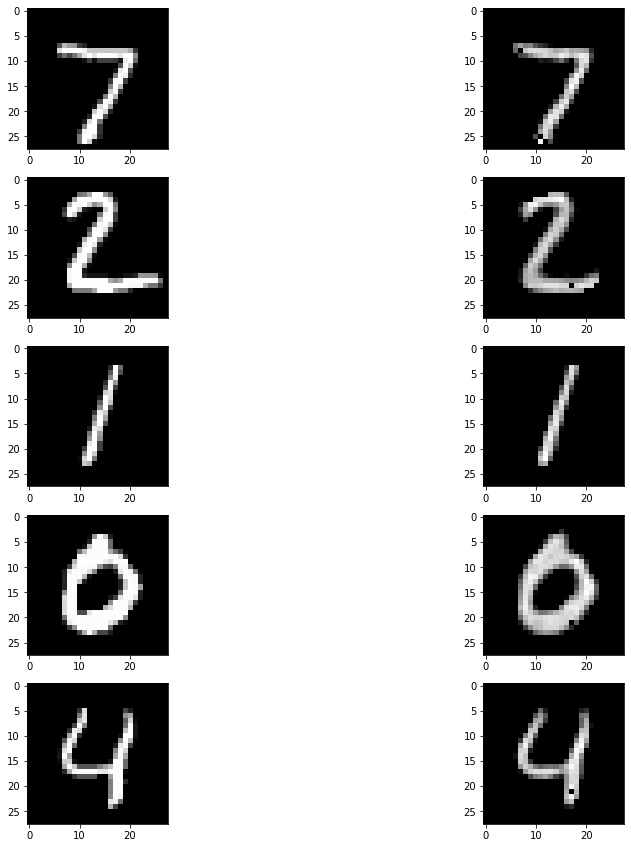

In [ ]:
rows = 5
fig,axs = plt.subplots(rows,2,figsize=(15,15))

for i in range(len(X_TEST[:rows])):
    
    values = X_TEST[i]
    
    axs[i,0].imshow(values,cmap='gray')
    img = mod[0].predict(values.reshape(-1,28,28,1))[0]
    axs[i,1].imshow(img,cmap='gray')
    
   
    

In [6]:
from os import walk
import warnings
warnings.filterwarnings( "ignore", message = "WARNING", )
def compare_models(mypath,img):
    

    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(dirnames)
        break
        
   
    fig,axe = plt.subplots(2,5,figsize=(15,15))
    i = -1
    j=0
    count = 0
    for path in f:
        p ="Models/"+str(path)
        if p== 'Models/dense_0_values_[64, 32, 16]_output_64_epochs_10_':
            print("Trueeeeeeeeee")
        print(p)
        model = keras.models.load_model(p)
        img2 = model.predict(img.reshape(28,28).reshape(-1,28,28,1))[0]
        j = count%5 
        
        if j==0:
            i = i + 1
       
        axe[i,j].imshow(img2.reshape(28,28),cmap='gray')
        count = count + 1
        

Models/dense_0_values_[64, 32, 16]_output_2_epochs_10_
Trueeeeeeeeee
Models/dense_0_values_[64, 32, 16]_output_64_epochs_10_
Models/dense_2_values_[512, 128]_output_64_epochs_10_
Models/dense_3_values_[512, 256, 128]_output_64_epochs_10_
Models/dense_3_values_[64, 32, 16]_output_3_epochs_10_
Models/dense_3_values_[64, 32, 16]_output_8_epochs_3_


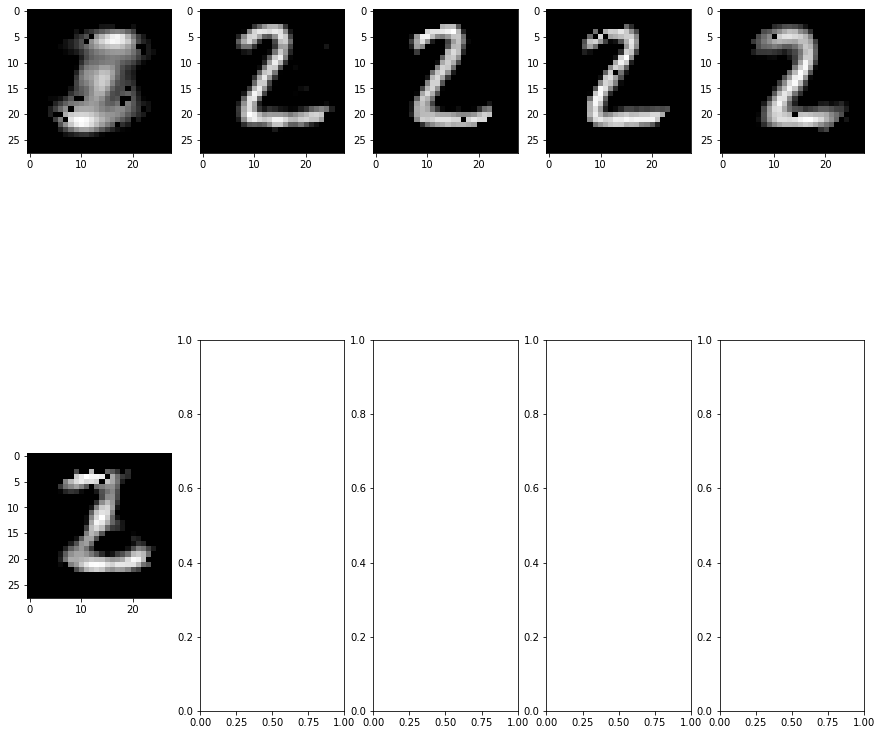

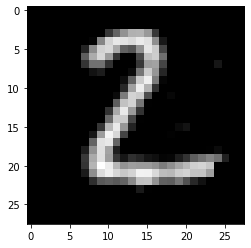

In [ ]:
m = keras.models.load_model("Models/dense_0_values_[64, 32, 16]_output_64_epochs_10_")
im = m.predict(X_TEST[1].reshape((-1,28,28,1)))[0]
plt.imshow(im,cmap='gray')

In [7]:
from keras.layers import Dense,Conv2D,MaxPool2D,UpSampling2D,Input
from keras import Model

In [8]:
Names = []

In [9]:
Models = []

In [43]:
#Conv layer


def Conv_Autoencoder(x_train,y_train,conv=1,shape_x=28, shape_y=28, conv_values = [], channel=1, filter_size=(3,3), pool_size=(2,2),epochs= 5,batch_size = 128,decay=1e-6):
    
    encoder_input = Input(shape=(shape_x,shape_y, channel))
    #conv_layers = []
    layers = []
    shape = shape_x


   

    for i in range(conv):
      
        
        shape = int(shape/2) # output of every new Conv would be 1/2 of prev by default
        if shape % 2 !=0:
          shape = shape + 1
       
      
        if i == 0:
            layer = Conv2D(shape,filter_size,activation='relu',padding='same')(encoder_input)
        
        else:
            layer = Conv2D(shape,filter_size,activation='relu',padding='same')(layer)
        
        layer = MaxPool2D(pool_size = pool_size,padding='same')(layer)
     
        
    
    encoded = layer # last layer
    encoder = Model(encoder_input, encoded)
  
    for i in range(conv):
        
        if i == 0:
            layer = Conv2D(shape,filter_size,activation = 'relu',padding='same')(encoded)
        else:
            layer = Conv2D(shape,filter_size,activation = 'relu',padding='same')(layer)
        
        layer = UpSampling2D(pool_size)(layer)
        shape = shape * 2
        
    
    decoded = Conv2D(1, filter_size, activation = 'relu' ,padding = "same")(layer)
    # ????
    autoencoder = Model(encoder_input,decoded)
    
    optimizer = keras.optimizers.Adam(decay=decay)
    autoencoder.compile( optimizer = optimizer , loss='mse')#loss = 'binary_crossentropy' )
    
    print(autoencoder.summary())
    
    autoencoder.fit(x_train,y_train,epochs=epochs,batch_size = batch_size )
    name = "Models/CNN_MODELS_epochs_{}_channel_{}_covlayer_{}_batch_size_{}_decay{}_".format(epochs,channel,conv,batch_size,decay)
    autoencoder.save(name)
    Models.append(autoencoder)
    Names.append(name)
    return autoencoder
        
        
        

In [44]:
x = X_TRAIN#.reshape((len(X_TRAIN),28,28, 1))
model = Conv_Autoencoder(x,x,conv=2,epochs=100)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 14)        140       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 14)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 8)         1016      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 14, 14, 8)         0  

In [ ]:
#!zip -r /content/file.zip /content/CNN_MODELS_epochs_5_channel_1_covlayer_1_batch_size_128_

['Models/CNN_MODELS_epochs_5_channel_1_covlayer_1_batch_size_128_', 'Models/CNN_MODELS_epochs_10_channel_1_covlayer_1_batch_size_128_', 'Models/CNN_MODELS_epochs_10_channel_1_covlayer_1_batch_size_128_decay1e-06_', 'Models/CNN_MODELS_epochs_50_channel_1_covlayer_1_batch_size_128_decay1e-06_', 'Models/CNN_MODELS_epochs_100_channel_1_covlayer_2_batch_size_128_decay1e-06_', 'Models/CNN_MODELS_epochs_50_channel_1_covlayer_1_batch_size_128_decay1e-06_', 'Models/CNN_MODELS_epochs_100_channel_1_covlayer_2_batch_size_128_decay1e-06_']
7
0 Models/CNN_MODELS_epochs_5_channel_1_covlayer_1_batch_size_128_ dict_keys([])
Error :  0
1 Models/CNN_MODELS_epochs_10_channel_1_covlayer_1_batch_size_128_ dict_keys(['loss'])
2 Models/CNN_MODELS_epochs_10_channel_1_covlayer_1_batch_size_128_decay1e-06_ dict_keys([])
Error :  2
3 Models/CNN_MODELS_epochs_50_channel_1_covlayer_1_batch_size_128_decay1e-06_ dict_keys([])
Error :  3
4 Models/CNN_MODELS_epochs_100_channel_1_covlayer_2_batch_size_128_decay1e-06_ di

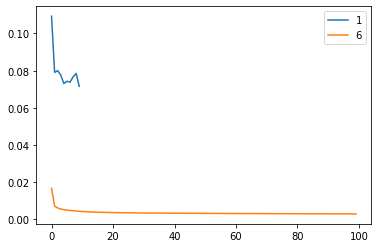

In [45]:


count = 0
lig = []
print(Names)
print(len(Models))
for models in Models:
  
  print(count,Names[count],models.history.history.keys())
  try:
    loss = models.history.history['loss']
    ep = models.history.epoch
    lig.append(count)
    
    plt.plot(ep,loss)
  except:
    print("Error : ",count)
    pass
  count = count + 1
plt.legend(lig)
#model.history.epoch

In [20]:
Models


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_TEST.shape

(10000, 28, 28)

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


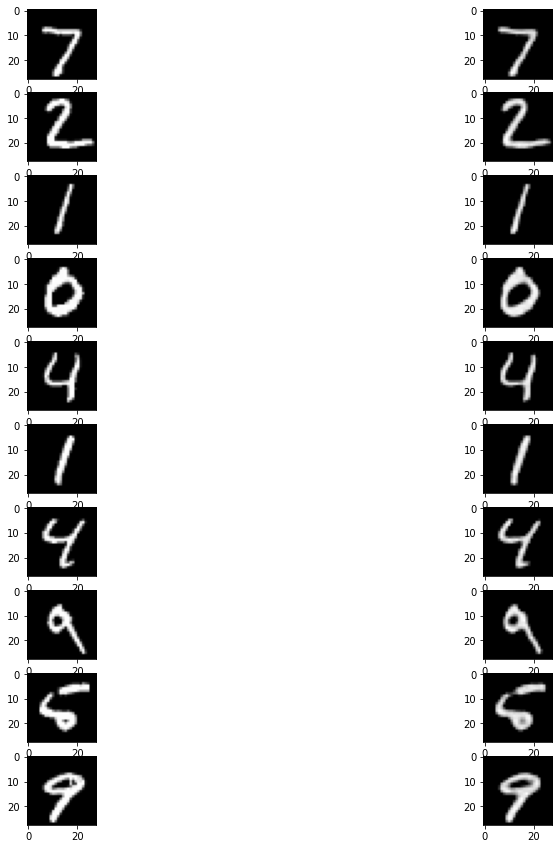

In [46]:
rows = 10
fig,axs = plt.subplots(rows,2,figsize=(15,15))

for i in range(len(X_TEST[:rows])):
    
    values = X_TEST[i]
    
    axs[i,0].imshow(values,cmap='gray')
    img = model.predict(values.reshape(-1,28,28,1))[0]
    print(img.shape)
    axs[i,1].imshow(img.reshape(28,28),cmap='gray')
    
   
    

Models/CNN_MODELS_epochs_5_channel_1_covlayer_1_batch_size_128_
Models/CNN_MODELS_epochs_100_channel_1_covlayer_2_batch_size_128_decay1e-06_
Models/CNN_MODELS_epochs_10_channel_1_covlayer_1_batch_size_128_
Models/CNN_MODELS_epochs_10_channel_1_covlayer_1_batch_size_128_decay1e-06_
Models/CNN_MODELS_epochs_50_channel_1_covlayer_1_batch_size_128_decay1e-06_


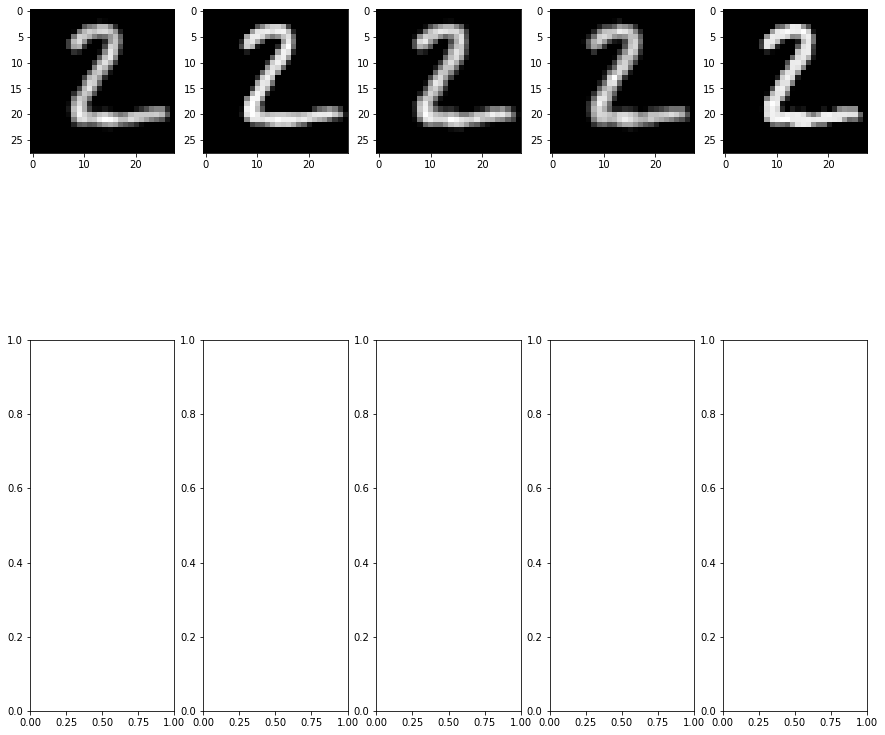

In [47]:
values = X_TEST[1]
compare_models(r"/content/Models",values)

In [ ]:
Names

['Models/CNN_MODELS_epochs_5_channel_1_covlayer_1_batch_size_128_']